In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization


train_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
sample_submission = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')
train_img_set = os.listdir('/kaggle/input/histopathologic-cancer-detection/train/')
test_img_set = os.listdir('/kaggle/input/histopathologic-cancer-detection/test/')


In [3]:
train_labels.head(5)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


Count of label 0 in train_labels: 130908
Count of label 1 in train_labels: 89117

Image Size: 96 x 96


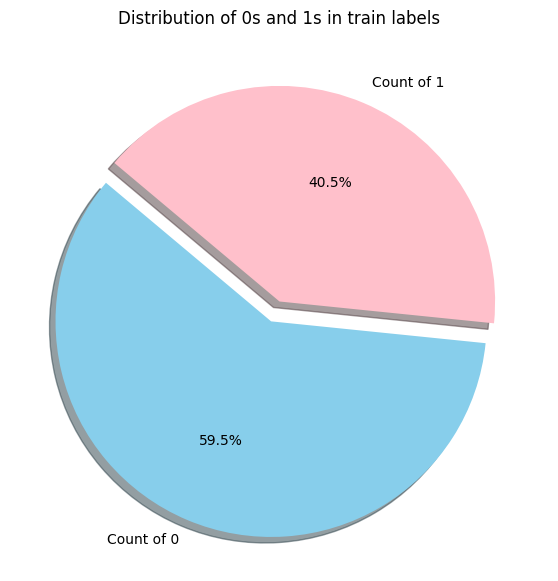

In [4]:
counts = np.count_nonzero(train_labels['label'])

print(f'Count of label 0 in train_labels: {len(train_labels) - counts}')
print(f'Count of label 1 in train_labels: {counts}')

with Image.open(os.path.join('/kaggle/input/histopathologic-cancer-detection/train/', train_img_set[0])) as image:
    width, height = image.size
    
print(f'\nImage Size: {width} x {height}')  

labels = ['Count of 0', 'Count of 1']
sizes = [len(train_labels) - counts, counts]
colors = ['skyblue', 'pink']
explode = (0.1, 0)  

# Plotting the pie chart
plt.figure(figsize=(7, 7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=140)
plt.title('Distribution of 0s and 1s in train labels')
plt.show()

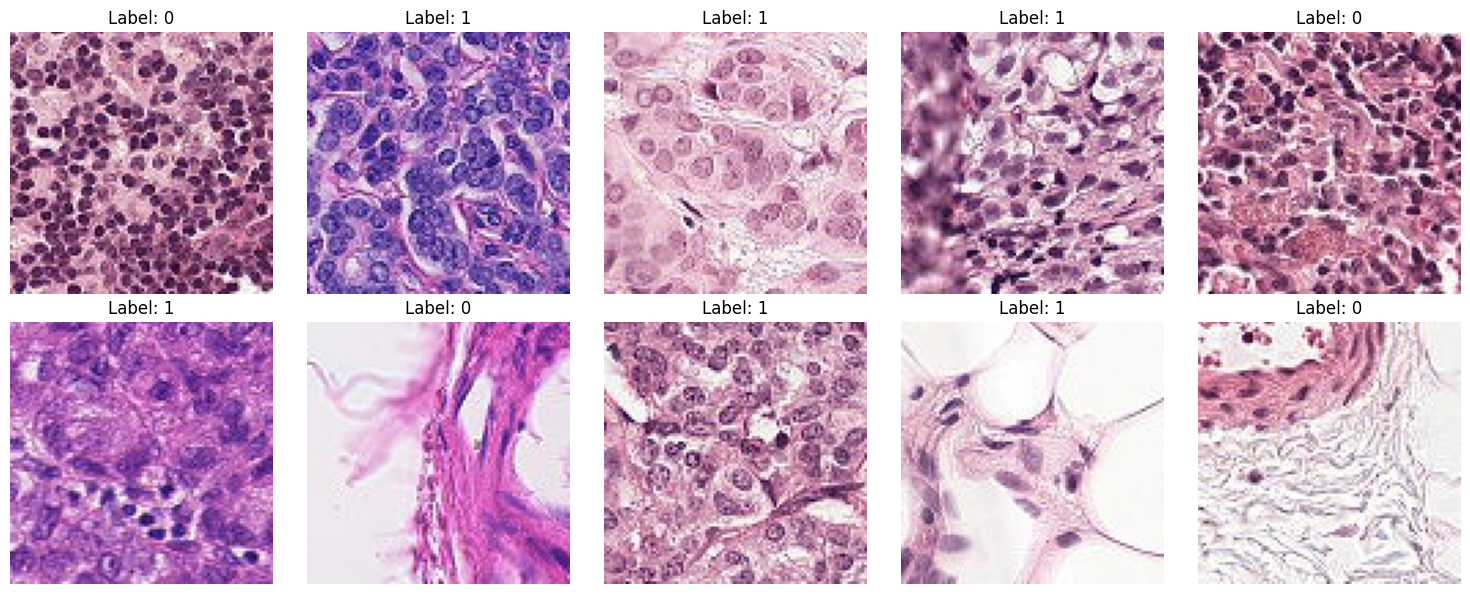

In [5]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
random_images = random.sample(train_img_set, 10)


for ax, img_name in zip(axes.flatten(), random_images):
    img_path = os.path.join('/kaggle/input/histopathologic-cancer-detection/train/', img_name)
    img = mpimg.imread(img_path)
    label = train_labels[train_labels['id'] == img_name.split('.')[0]]['label'].values[0]
    
    ax.imshow(img)
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data preprocessing

"""
 Converting label to string and adding .tif extension to images so that we can use this data 
 to create a dataframe out of it. Also rescaling/normalizing the images to the range 0-1 
 can help with training stability and convergence.
 
"""

train_labels['label'] = train_labels['label'].map(lambda x: str(x))
train_labels['id'] = train_labels['id'].map(lambda x: f"{x}.tif")


gen = ImageDataGenerator(validation_split=0.25, rescale=1./255)

train_generator = gen.flow_from_dataframe(train_labels, directory='/kaggle/input/histopathologic-cancer-detection/train/', x_col='id', y_col='label', subset="training", target_size=(96, 96), batch_size=256, class_mode='binary', workers=4, use_multiprocessing=True)
valid_generator = gen.flow_from_dataframe(train_labels, directory='/kaggle/input/histopathologic-cancer-detection/train/', x_col='id', y_col='label', subset="validation", target_size=(96, 96), batch_size=256, class_mode='binary', workers=4, use_multiprocessing=True)

Found 165019 validated image filenames belonging to 2 classes.
Found 55006 validated image filenames belonging to 2 classes.


## Model 1

Convolutional layers: The model uses three convolutional layers with increasing filter counts (32, 64, 128). This allows the network to learn hierarchical features, from simple edges to more complex patterns.

Max pooling: After each convolutional layer, max pooling reduces spatial dimensions, making the model more computationally efficient and helping to achieve spatial invariance.

ReLU activation: Used in convolutional layers, ReLU helps introduce non-linearity and can help mitigate the vanishing gradient problem.

Dropout: The 50% dropout before the final layer helps prevent overfitting by randomly deactivating half of the neurons during training.

Binary output: The final dense layer with sigmoid activation is appropriate for binary classification, outputting a probability between 0 and 1.


In [20]:
model1 = Sequential([
    Input(shape=(96, 96, 3)),
    Rescaling(1./255),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


model1.compile(loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │        12,801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 106,049 (414.25 KB)

 Trainable params: 106,049 (414.25 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history = model1.fit(train_generator, epochs=7, validation_data=valid_generator)

Epoch 1/7
645/645 ━━━━━━━━━━━━━━━━━━━━ 416s 625ms/step - accuracy: 0.5935 - loss: 0.6738 - val_accuracy: 0.5955 - val_loss: 0.6501
Epoch 2/7
645/645 ━━━━━━━━━━━━━━━━━━━━ 302s 464ms/step - accuracy: 0.5888 - loss: 0.6432 - val_accuracy: 0.6255 - val_loss: 0.6198
Epoch 3/7
645/645 ━━━━━━━━━━━━━━━━━━━━ 308s 473ms/step - accuracy: 0.6774 - loss: 0.5954 - val_accuracy: 0.7484 - val_loss: 0.5224
Epoch 4/7
645/645 ━━━━━━━━━━━━━━━━━━━━ 315s 484ms/step - accuracy: 0.7208 - loss: 0.5495 - val_accuracy: 0.7693 - val_loss: 0.4934
Epoch 5/7
645/645 ━━━━━━━━━━━━━━━━━━━━ 316s 487ms/step - accuracy: 0.7470 - loss: 0.5164 - val_accuracy: 0.7607 - val_loss: 0.4982
Epoch 6/7
645/645 ━━━━━━━━━━━━━━━━━━━━ 304s 468ms/step - accuracy: 0.7678 - loss: 0.4901 - val_accuracy: 0.7807 - val_loss: 0.4700
Epoch 7/7
645/645 ━━━━━━━━━━━━━━━━━━━━ 305s 470ms/step - accuracy: 0.7756 - loss: 0.4804 - val_accuracy: 0.7919 - val_loss: 0.4541


In [22]:
def plot_loss(history, label=None):
    plt.figure(figsize=(8, 6))

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss {f"({label})" if label else ""}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.show()

def plot_accuracy(history, label=None):

    plt.figure(figsize=(8, 6))

    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy {f"({label})" if label else ""}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.show()
    

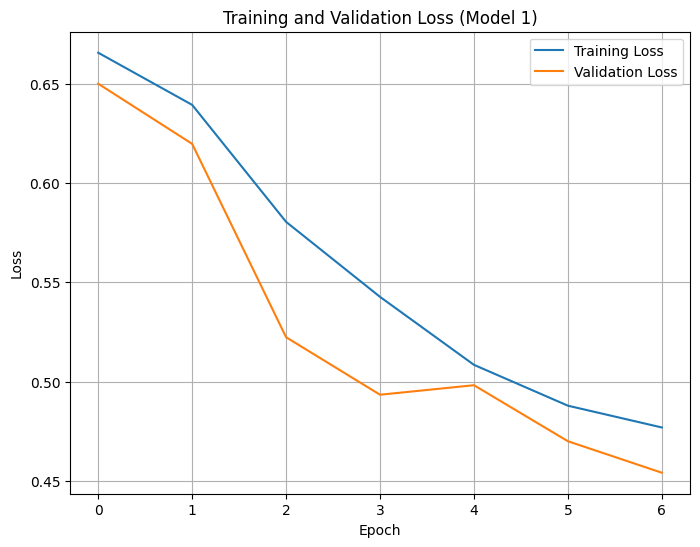

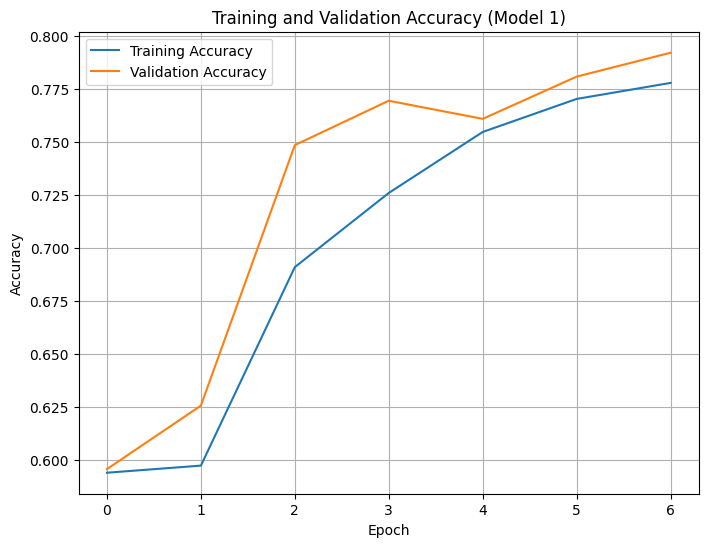

In [23]:
plot_loss(history, label='Model 1')

plot_accuracy(history, label='Model 1')

## Model2

This model (model2) is a deeper and more complex version of the previous architecture. 
With more convolutional layers, this model can potentially learn more complex features.
Adam optimizer is also used which can adapt the learning rate during training.
Also Batch optimizer is used to speed up the model's training time.


In [16]:
model2 = Sequential([
    Input(shape=(96, 96, 3)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Flatten(),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])


model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 96, 96, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 96, 96, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 48, 48, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 48, 48, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 147456)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 147456)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │     4,718,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,274,241 (20.12 MB)

 Trainable params: 5,274,113 (20.12 MB)

 Non-trainable params: 128 (512.00 B)

In [17]:
history = model2.fit(train_generator, epochs=7, validation_data=valid_generator)

Epoch 1/7


W0000 00:00:1723237632.007304     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.7675 - loss: 0.5648

W0000 00:00:1723237995.182105     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


645/645 ━━━━━━━━━━━━━━━━━━━━ 496s 754ms/step - accuracy: 0.7676 - loss: 0.5645 - val_accuracy: 0.8610 - val_loss: 0.3366
Epoch 2/7


W0000 00:00:1723238117.793031     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


645/645 ━━━━━━━━━━━━━━━━━━━━ 316s 485ms/step - accuracy: 0.8656 - loss: 0.3191 - val_accuracy: 0.7930 - val_loss: 0.4278
Epoch 3/7
645/645 ━━━━━━━━━━━━━━━━━━━━ 310s 477ms/step - accuracy: 0.8942 - loss: 0.2627 - val_accuracy: 0.8866 - val_loss: 0.2761
Epoch 4/7
645/645 ━━━━━━━━━━━━━━━━━━━━ 311s 477ms/step - accuracy: 0.9137 - loss: 0.2193 - val_accuracy: 0.8472 - val_loss: 0.3486
Epoch 5/7
645/645 ━━━━━━━━━━━━━━━━━━━━ 303s 465ms/step - accuracy: 0.9293 - loss: 0.1852 - val_accuracy: 0.9218 - val_loss: 0.2021
Epoch 6/7
645/645 ━━━━━━━━━━━━━━━━━━━━ 307s 472ms/step - accuracy: 0.9390 - loss: 0.1622 - val_accuracy: 0.8338 - val_loss: 0.6389
Epoch 7/7
645/645 ━━━━━━━━━━━━━━━━━━━━ 305s 469ms/step - accuracy: 0.9473 - loss: 0.1407 - val_accuracy: 0.9178 - val_loss: 0.2193


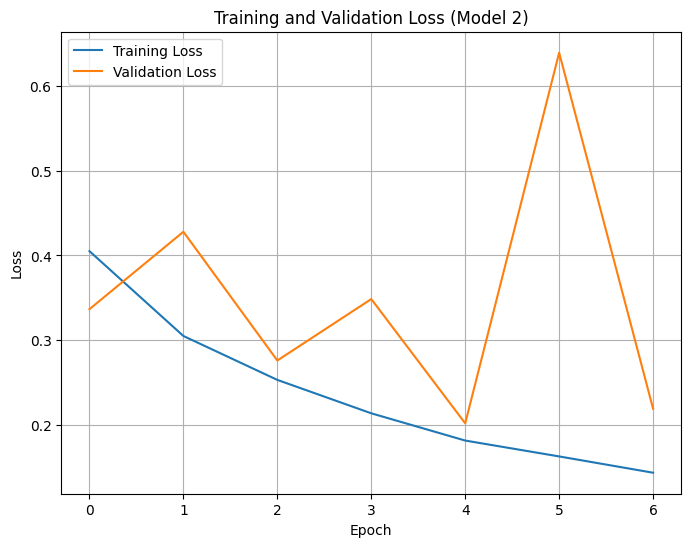

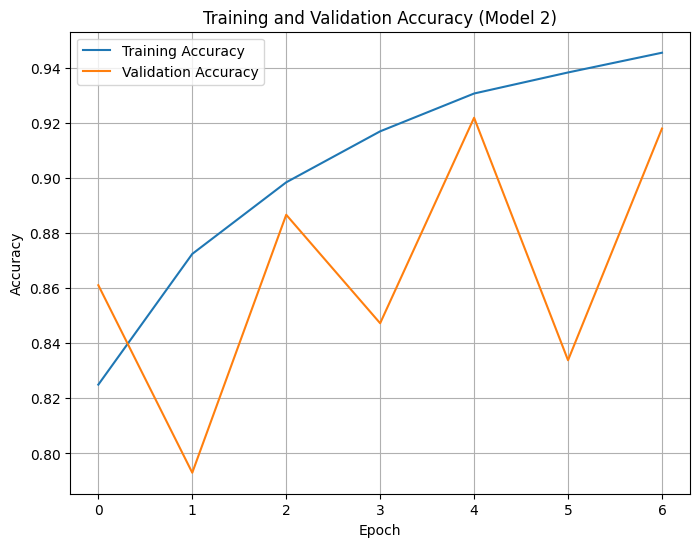

In [18]:
plot_loss(history, label='Model 2')

plot_accuracy(history, label='Model 2')

In [19]:
test_gen = ImageDataGenerator(rescale=1./255)

test_df = pd.DataFrame({'id':test_img_set})
test_data = test_gen.flow_from_dataframe(dataframe=test_df,
                                                    directory="/kaggle/input/histopathologic-cancer-detection/test/",
                                                    x_col='id', 
                                                    y_col=None,
                                                    batch_size=1,
                                                    class_mode=None,
                                                    target_size=(96,96), 
                                                    workers=4,
                                                    shuffle=False,
                                                    use_multiprocessing=True)

predictions = model2.predict(test_data)
predictions = np.transpose(predictions)[0]


submission_df = pd.DataFrame()
submission_df['id'] = test_df['id'].apply(lambda x: x.split('.')[0])
submission_df['label'] = (predictions >= 0.5).astype(int).flatten()
submission_df.to_csv('submission.csv', index=False)

Found 57458 validated image filenames.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57458/57458 ━━━━━━━━━━━━━━━━━━━━ 137s 2ms/step


Model 1 employs a straightforward architecture with three convolutional layers, each followed by max pooling, culminating in 128 filters. This design allows for basic feature extraction while maintaining computational efficiency. In contrast, Model 2 adopts a more sophisticated structure with paired convolutional layers (two layers of 64, 128, and 256 filters respectively) before each max pooling operation. This deeper architecture enables Model 2 to potentially capture more nuanced features. Model 1 uses a single dropout layer before the output, while Model 2 implements two dropout layers, possibly providing stronger regularization. Both models use ReLU activations and end with a sigmoid output for binary classification, but Model 2's increased depth and filter count make it more suitable for complex image patterns at the cost of increased computational demands and potential overfitting risk.

### Now, Let's try to tune the hyperparameters of model2

In [24]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization

dropout_rate = [0.3, 0.5]
learning_rate = [1e-2, 1e-3, 1e-4]
best_accuracy = 0
best_hyperparameters = {}

for dr in dropout_rate:
    for lr in learning_rate:
        
        print(f"Testing model with dropout={dr}, learning_rate={lr}")

        model2_mod = Sequential([
            Input(shape=(96, 96, 3)),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2)),
            BatchNormalization(),
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2)),
            Conv2D(256, (3, 3), activation='relu', padding='same'),
            Flatten(),
            Dropout(dr),
            Dense(1, activation='sigmoid')
        ])


        model2_mod.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
        history = model2_mod.fit(train_generator, epochs=5, validation_data=valid_generator)
        
        val_accuracy = np.max(history.history['val_accuracy'])
        print(f"Validation accuracy: {val_accuracy}")

              
        if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_hyperparameters = {
                    'dropout': dr,
                    'learning_rate': lr
                }
        
        train_generator.reset()
        valid_generator.reset()
        
print(f"Best hyperparameters: {best_hyperparameters}")
print(f"Best validation accuracy: {best_accuracy}")
                

Testing model with dropout=0.3, learning_rate=0.01
Epoch 1/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 320s 483ms/step - accuracy: 0.5924 - loss: 13.2807 - val_accuracy: 0.5955 - val_loss: 0.6748
Epoch 2/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 311s 478ms/step - accuracy: 0.5946 - loss: 0.6752 - val_accuracy: 0.5955 - val_loss: 0.6749
Epoch 3/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 318s 490ms/step - accuracy: 0.5950 - loss: 0.6750 - val_accuracy: 0.5955 - val_loss: 0.6748
Epoch 4/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 316s 486ms/step - accuracy: 0.5936 - loss: 0.6755 - val_accuracy: 0.5955 - val_loss: 0.6748
Epoch 5/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 306s 470ms/step - accuracy: 0.5950 - loss: 0.6751 - val_accuracy: 0.5955 - val_loss: 0.6748
Validation accuracy: 0.5955350399017334
Testing model with dropout=0.3, learning_rate=0.001
Epoch 1/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 315s 477ms/step - accuracy: 0.8002 - loss: 0.4753 - val_accuracy: 0.8446 - val_loss: 0.3854
Epoch 2/5
645/645 ━━━━━━━━━━━━━━━━━━━━ 308s 474ms/step - accuracy: 0.8

In summary, Model 1, the simplest CNN, offers a lightweight architecture suitable for basic tasks and small datasets, trading off potential accuracy for speed and simplicity. Model 2 expands on this with a deeper structure, potentially capturing more intricate features at the cost of increased computational demands and data requirements. Model 1 might suffice for straightforward tasks, Model 2 could offer a middle ground for more complex problems.

## What likely helped improve performance:

Increasing model depth and complexity from Model 1 to Model 2. The additional convolutional layers and filters in Model 2 likely allowed it to capture more complex features.
Using dropout layers in both Model 1 and Model 2, which helps prevent overfitting.


## Future improvements to try:

Introducing and experimenting with the 512-unit dense layer in Models 1 and 2.
Experimenting with learning rate schedules for the Adam optimizer.
Trying different regularization techniques, such as L1/L2 regularization or increasing/decreasing dropout rates.
Implementing data augmentation techniques to artificially expand your dataset and improve generalization.
Trying ensemble methods, combining predictions from multiple models.
Implementing cross-validation to get a more robust estimate of model performance and prevent overfitting to the validation set.